In [1]:
import os
import cv2 as cv
import numpy as np

In [2]:
video_folder = "video/fall"
output_base_folder = "frames_fall/"
target_size = (320, 240)

def extract_rgb_frames(video_path, output_folder, frame_step=1):
    cap = cv.VideoCapture(video_path)
    os.makedirs(output_folder, exist_ok=True)

    frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    print(f"Processing {video_path} - Total Frames: {frame_count}")

    for i in range(0, frame_count, frame_step):  
        cap.set(cv.CAP_PROP_POS_FRAMES, i)  
        ret, frame = cap.read()
        if not ret:
            break

        h, w, _ = frame.shape  

        
        if w >= 2 * h:  
            rgb_frame = frame[:, w//2:, :]  
        else:
            rgb_frame = frame  

        frame_resized = cv.resize(rgb_frame, target_size, interpolation=cv.INTER_AREA)

        frame_path = os.path.join(output_folder, f"frame_{i:04d}.jpg")
        cv.imwrite(frame_path, frame_resized)

    cap.release()
    print(f"✅ Finished {video_path} - Extracted frames.")


video_files = [f for f in os.listdir(video_folder) if f.endswith((".avi", ".mp4"))]

for video_file in video_files:
    video_path = os.path.join(video_folder, video_file)
    output_folder = os.path.join(output_base_folder, os.path.splitext(video_file)[0])
    extract_rgb_frames(video_path, output_folder, frame_step=1)

print("✅ Done! RGB frames are extracted successfully.")


Processing video/fall\fall-01-cam0.mp4 - Total Frames: 160
✅ Finished video/fall\fall-01-cam0.mp4 - Extracted frames.
Processing video/fall\fall-02-cam0.mp4 - Total Frames: 110
✅ Finished video/fall\fall-02-cam0.mp4 - Extracted frames.
Processing video/fall\fall-03-cam0.mp4 - Total Frames: 215
✅ Finished video/fall\fall-03-cam0.mp4 - Extracted frames.
Processing video/fall\fall-04-cam0.mp4 - Total Frames: 96
✅ Finished video/fall\fall-04-cam0.mp4 - Extracted frames.
Processing video/fall\fall-05-cam0.mp4 - Total Frames: 151
✅ Finished video/fall\fall-05-cam0.mp4 - Extracted frames.
Processing video/fall\fall-06-cam0.mp4 - Total Frames: 100
✅ Finished video/fall\fall-06-cam0.mp4 - Extracted frames.
Processing video/fall\fall-07-cam0.mp4 - Total Frames: 156
✅ Finished video/fall\fall-07-cam0.mp4 - Extracted frames.
Processing video/fall\fall-08-cam0.mp4 - Total Frames: 91
✅ Finished video/fall\fall-08-cam0.mp4 - Extracted frames.
Processing video/fall\fall-09-cam0.mp4 - Total Frames: 185

In [3]:
video_folder = "video/adl"
output_base_folder = "frames_adl/"
target_size = (320, 240)

def extract_rgb_frames(video_path, output_folder, frame_step=1):
    cap = cv.VideoCapture(video_path)
    os.makedirs(output_folder, exist_ok=True)

    frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    print(f"Processing {video_path} - Total Frames: {frame_count}")

    for i in range(0, frame_count, frame_step):  
        cap.set(cv.CAP_PROP_POS_FRAMES, i)  
        ret, frame = cap.read()
        if not ret:
            break

        h, w, _ = frame.shape  

        
        if w >= 2 * h:  
            rgb_frame = frame[:, w//2:, :]  
        else:
            rgb_frame = frame  

        frame_resized = cv.resize(rgb_frame, target_size, interpolation=cv.INTER_AREA)

        frame_path = os.path.join(output_folder, f"frame_{i:04d}.jpg")
        cv.imwrite(frame_path, frame_resized)

    cap.release()
    print(f"✅ Finished {video_path} - Extracted frames.")


video_files = [f for f in os.listdir(video_folder) if f.endswith((".avi", ".mp4"))]

for video_file in video_files:
    video_path = os.path.join(video_folder, video_file)
    output_folder = os.path.join(output_base_folder, os.path.splitext(video_file)[0])
    extract_rgb_frames(video_path, output_folder, frame_step=1)

print("✅ Done! RGB frames are extracted successfully.")


Processing video/adl\adl-01-cam0.mp4 - Total Frames: 150
✅ Finished video/adl\adl-01-cam0.mp4 - Extracted frames.
Processing video/adl\adl-02-cam0.mp4 - Total Frames: 180
✅ Finished video/adl\adl-02-cam0.mp4 - Extracted frames.
Processing video/adl\adl-03-cam0.mp4 - Total Frames: 180
✅ Finished video/adl\adl-03-cam0.mp4 - Extracted frames.
Processing video/adl\adl-04-cam0.mp4 - Total Frames: 150
✅ Finished video/adl\adl-04-cam0.mp4 - Extracted frames.
Processing video/adl\adl-05-cam0.mp4 - Total Frames: 180
✅ Finished video/adl\adl-05-cam0.mp4 - Extracted frames.
Processing video/adl\adl-06-cam0.mp4 - Total Frames: 230
✅ Finished video/adl\adl-06-cam0.mp4 - Extracted frames.
Processing video/adl\adl-07-cam0.mp4 - Total Frames: 180
✅ Finished video/adl\adl-07-cam0.mp4 - Extracted frames.
Processing video/adl\adl-08-cam0.mp4 - Total Frames: 180
✅ Finished video/adl\adl-08-cam0.mp4 - Extracted frames.
Processing video/adl\adl-09-cam0.mp4 - Total Frames: 150
✅ Finished video/adl\adl-09-cam

In [ ]:
import os
import cv2 as cv
import pandas as pd
import mediapipe as mp
import numpy as np
from collections import deque


SELECTED_LANDMARKS = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]

mpPose = mp.solutions.pose
pose = mpPose.Pose(min_detection_confidence=0.8, min_tracking_confidence=0.8)

acceleration_queue = deque(maxlen=5)

def calculate_acceleration(prev_velocity, current_velocity, time_interval):
    if prev_velocity is None or current_velocity is None or time_interval == 0:
        return np.zeros_like(current_velocity)
    return (current_velocity - prev_velocity) / time_interval

def detectPose(image, pose, prev_landmarks, prev_velocity, time_interval):
    imgHeight, imgWidth, _ = image.shape
    imageRGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    results = pose.process(imageRGB)
    
    landmarks = []
    neck_y = None
    
    if results.pose_landmarks:
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            if idx in SELECTED_LANDMARKS:
                landmarks.append((landmark.x * imgWidth, landmark.y * imgHeight))
        
        left_shoulder = results.pose_landmarks.landmark[11]
        right_shoulder = results.pose_landmarks.landmark[12]
        neck_y = (left_shoulder.y + right_shoulder.y) / 2 * imgHeight
    
    current_velocity = None
    acceleration = None
    
    if prev_landmarks and landmarks:
        displacement = np.array(landmarks) - np.array(prev_landmarks)
        current_velocity = displacement / time_interval
        acceleration = calculate_acceleration(prev_velocity, current_velocity, time_interval)
        acceleration_queue.append(np.mean(np.abs(acceleration)))
    
    return results, landmarks, neck_y, current_velocity, acceleration

def classify_pose(neck_y, mean_acceleration, image_height):
    if neck_y is None:
        return "UNKNOWN"
    
    fall_threshold = 0.6 * image_height
    acceleration_threshold = 5  

    if neck_y > fall_threshold and mean_acceleration > acceleration_threshold:
        return "FALL"
    else:
        return "ADL"  
def processFrames(input_folders, output_csv, output_image_folder):
    data = []
    os.makedirs(output_image_folder, exist_ok=True)
    
    for label, folder_path in input_folders.items():
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                output_subfolder = os.path.join(output_image_folder, subfolder)
                os.makedirs(output_subfolder, exist_ok=True)
                
                prev_landmarks = None
                prev_velocity = None
                time_interval = 1 / 30 
                
                for filename in sorted(os.listdir(subfolder_path)):
                    if filename.endswith(('.jpg', '.png')):
                        file_path = os.path.join(subfolder_path, filename)
                        print(f"Processing: {file_path}")
                        
                        image = cv.imread(file_path)
                        if image is None:
                            print(f"Error reading image: {file_path}")
                            continue
                        
                        results, landmarks, neck_y, current_velocity, acceleration = detectPose(
                            image, pose, prev_landmarks, prev_velocity, time_interval
                        )
                        
                        if results.pose_landmarks:
                            mp.solutions.drawing_utils.draw_landmarks(
                                image, results.pose_landmarks, mpPose.POSE_CONNECTIONS
                            )
                            processed_image_path = os.path.join(output_subfolder, filename)
                            cv.imwrite(processed_image_path, image)
                        
                        if landmarks:
                            flattened_landmarks = [coord for landmark in landmarks for coord in landmark]
                            
                            label = classify_pose(neck_y, np.mean(acceleration_queue) if acceleration_queue else 0, image.shape[0])
                            
                            flattened_landmarks.append(label)
                            data.append(flattened_landmarks)
                        
                        prev_landmarks = landmarks
                        prev_velocity = current_velocity
    
    columns = [f'{axis}{i+1}' for i in range(len(SELECTED_LANDMARKS)) for axis in ['x', 'y']] + ['Label']
    
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_csv, index=False)

input_folders = {
    'adl': 'frames_adl',
    'fall': 'frames_fall'
}
output_csv = 'pose_data_2d.csv'
output_image_folder = 'processed_images_train'

processFrames(input_folders, output_csv, output_image_folder)


Processing: frames_adl\adl-01-cam0\frame_0000.jpg
Processing: frames_adl\adl-01-cam0\frame_0001.jpg
Processing: frames_adl\adl-01-cam0\frame_0002.jpg
Processing: frames_adl\adl-01-cam0\frame_0003.jpg
Processing: frames_adl\adl-01-cam0\frame_0004.jpg
Processing: frames_adl\adl-01-cam0\frame_0005.jpg
Processing: frames_adl\adl-01-cam0\frame_0006.jpg
Processing: frames_adl\adl-01-cam0\frame_0007.jpg
Processing: frames_adl\adl-01-cam0\frame_0008.jpg
Processing: frames_adl\adl-01-cam0\frame_0009.jpg
Processing: frames_adl\adl-01-cam0\frame_0010.jpg
Processing: frames_adl\adl-01-cam0\frame_0011.jpg
Processing: frames_adl\adl-01-cam0\frame_0012.jpg
Processing: frames_adl\adl-01-cam0\frame_0013.jpg
Processing: frames_adl\adl-01-cam0\frame_0014.jpg
Processing: frames_adl\adl-01-cam0\frame_0015.jpg
Processing: frames_adl\adl-01-cam0\frame_0016.jpg
Processing: frames_adl\adl-01-cam0\frame_0017.jpg
Processing: frames_adl\adl-01-cam0\frame_0018.jpg
Processing: frames_adl\adl-01-cam0\frame_0019.jpg


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


train_df = pd.read_csv('pose_data_2d.csv')
test_df = pd.read_csv('pose_data_2d_test.csv')

train_features = train_df.iloc[:, :-1].values
train_labels = train_df['Label'].values
test_features = test_df.iloc[:, :-1].values
test_labels = test_df['Label'].values


label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)


train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)


sequence_length = 12
num_features = train_features.shape[1]

def create_sequences(features, labels, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length + 1):
        X.append(features[i:i + seq_length])
        y.append(labels[i + seq_length - 1])  
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_features, train_labels, sequence_length)
X_test, y_test = create_sequences(test_features, test_labels, sequence_length)

print(f"📌 X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"📌 X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


model = Sequential([
    LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])


model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


model.summary()


📌 X_train shape: (7204, 12, 26), y_train shape: (7204, 1)
📌 X_test shape: (591, 12, 26), y_test shape: (591, 1)


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 128)        │        79,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,881 (511.25 KB)

 Trainable params: 130,881 (511.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {'ADL': 0, 'FALL': 1}


In [30]:

batch_size = 16
epochs = 100


history = model.fit(
    X_train, y_train,  
    validation_split=0.2,  
    batch_size=batch_size,
    epochs=epochs,
    verbose=1  
)



model.save('lstm_fall_detection.h5')


Epoch 1/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8608 - loss: 0.3674 - val_accuracy: 0.7904 - val_loss: 0.5040
Epoch 2/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9826 - loss: 0.0702 - val_accuracy: 0.8300 - val_loss: 0.4708
Epoch 3/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9793 - loss: 0.0625 - val_accuracy: 0.8751 - val_loss: 0.3063
Epoch 4/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9878 - loss: 0.0416 - val_accuracy: 0.8751 - val_loss: 0.2585
Epoch 5/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9847 - loss: 0.0450 - val_accuracy: 0.8702 - val_loss: 0.3432
Epoch 6/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9863 - loss: 0.0397 - val_accuracy: 0.8806 - val_loss: 0.2794
Epoch 7/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9868 - loss: 0.0393 - val_accuracy: 0.9195 - val_loss: 0.1949
Epoch 8/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9884 - loss: 0.0322 - val_accu

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


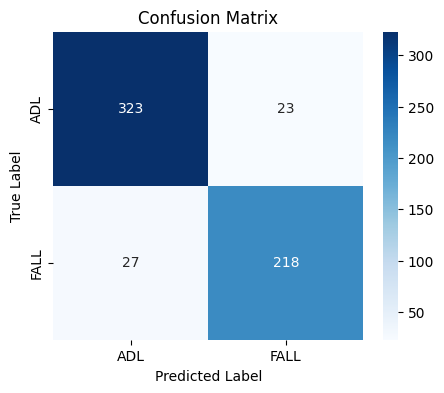


📌 Classification Report (Per Class):
              precision    recall  f1-score   support

         ADL       0.92      0.93      0.93       346
        FALL       0.90      0.89      0.90       245

    accuracy                           0.92       591
   macro avg       0.91      0.91      0.91       591
weighted avg       0.92      0.92      0.92       591


📊 Model Performance Summary:
🔹 Accuracy: 0.9154
🔹 Macro Avg F1-score: 0.9126
🔹 Weighted Avg F1-score: 0.9153
🔹 Macro Avg Precision: 0.9137
🔹 Macro Avg Recall: 0.9117


In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


from tensorflow.keras.models import load_model


from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# โหลดโมเดล
model_g = load_model('lstm_fall_detection.h5')

# ทำนายผล
y_pred = model_g.predict(X_test)

# แปลงค่าให้เป็น 0 หรือ 1 (เนื่องจากใช้ Sigmoid activation)
y_pred = (y_pred > 0.5).astype(int)

# แปลง y_test เป็น 1D
y_test_flat = y_test.reshape(-1)

# แสดง Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ADL', 'FALL'], yticklabels=['ADL', 'FALL'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# แสดง Classification Report
report = classification_report(y_test_flat, y_pred, target_names=['ADL', 'FALL'], output_dict=True)

# แสดงค่า Precision, Recall, F1-score ของแต่ละคลาส
print("\n📌 Classification Report (Per Class):")
print(classification_report(y_test_flat, y_pred, target_names=['ADL', 'FALL']))

# แสดงค่าเฉลี่ยรวมของโมเดล
print("\n📊 Model Performance Summary:")
print(f"🔹 Accuracy: {report['accuracy']:.4f}")
print(f"🔹 Macro Avg F1-score: {report['macro avg']['f1-score']:.4f}")
print(f"🔹 Weighted Avg F1-score: {report['weighted avg']['f1-score']:.4f}")
print(f"🔹 Macro Avg Precision: {report['macro avg']['precision']:.4f}")
print(f"🔹 Macro Avg Recall: {report['macro avg']['recall']:.4f}")




c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


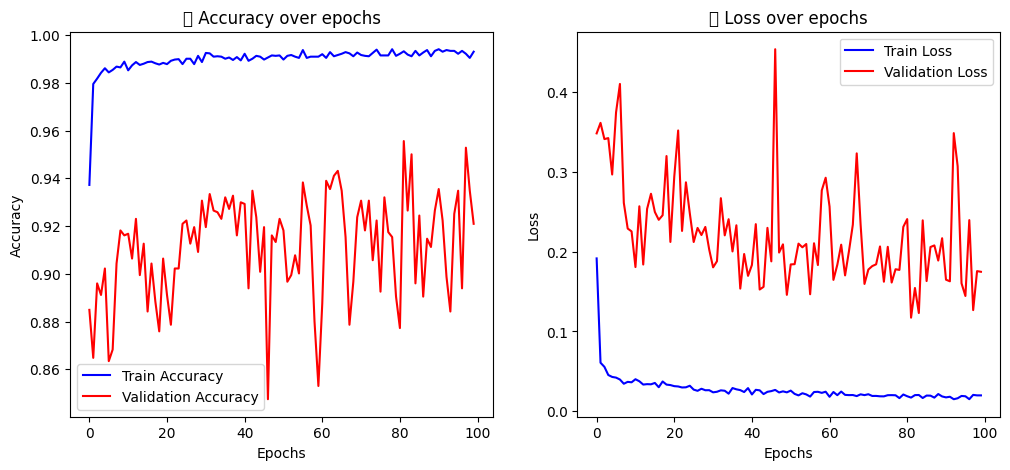

In [25]:
import matplotlib.pyplot as plt


history_dict = history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy', color='b')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('📈 Accuracy over epochs')

# กราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss', color='b')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('📉 Loss over epochs')

plt.show()


In [3]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU

model_g = Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


model_g.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])




batch_size = 16
epochs = 100


history_g = model_g.fit(
    X_train, y_train,  
    validation_split=0.2,  
    batch_size=batch_size,
    epochs=epochs,
    verbose=1  
)



model_g.save('gru_fall_detection.h5')


Epoch 1/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9064 - loss: 0.2530 - val_accuracy: 0.8550 - val_loss: 0.3228
Epoch 2/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9817 - loss: 0.0667 - val_accuracy: 0.8737 - val_loss: 0.3303
Epoch 3/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9853 - loss: 0.0484 - val_accuracy: 0.8626 - val_loss: 0.3651
Epoch 4/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9870 - loss: 0.0456 - val_accuracy: 0.8827 - val_loss: 0.3393
Epoch 5/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9874 - loss: 0.0390 - val_accuracy: 0.8758 - val_loss: 0.3815
Epoch 6/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9851 - loss: 0.0401 - val_accuracy: 0.8612 - val_loss: 0.3880
Epoch 7/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9887 - loss: 0.0370 - val_accuracy: 0.8654 - val_loss: 0.4382
Epoch 8/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9869 - loss: 0.0355 - val_

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


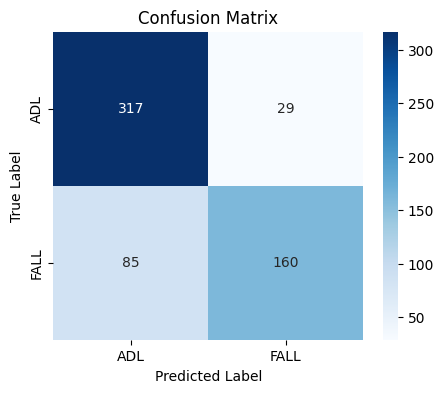


📌 Classification Report (Per Class):
              precision    recall  f1-score   support

         ADL       0.79      0.92      0.85       346
        FALL       0.85      0.65      0.74       245

    accuracy                           0.81       591
   macro avg       0.82      0.78      0.79       591
weighted avg       0.81      0.81      0.80       591


📊 Model Performance Summary:
🔹 Accuracy: 0.8071
🔹 Macro Avg F1-score: 0.7925
🔹 Weighted Avg F1-score: 0.8019
🔹 Macro Avg Precision: 0.8176
🔹 Macro Avg Recall: 0.7846


In [6]:

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# โหลดโมเดล
model_g = load_model('gru_fall_detection.h5')

# ทำนายผล
y_pred = model_g.predict(X_test)

# แปลงค่าให้เป็น 0 หรือ 1 (เนื่องจากใช้ Sigmoid activation)
y_pred = (y_pred > 0.5).astype(int)

# แปลง y_test เป็น 1D
y_test_flat = y_test.reshape(-1)

# แสดง Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ADL', 'FALL'], yticklabels=['ADL', 'FALL'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# แสดง Classification Report
report = classification_report(y_test_flat, y_pred, target_names=['ADL', 'FALL'], output_dict=True)

# แสดงค่า Precision, Recall, F1-score ของแต่ละคลาส
print("\n📌 Classification Report (Per Class):")
print(classification_report(y_test_flat, y_pred, target_names=['ADL', 'FALL']))

# แสดงค่าเฉลี่ยรวมของโมเดล
print("\n📊 Model Performance Summary:")
print(f"🔹 Accuracy: {report['accuracy']:.4f}")
print(f"🔹 Macro Avg F1-score: {report['macro avg']['f1-score']:.4f}")
print(f"🔹 Weighted Avg F1-score: {report['weighted avg']['f1-score']:.4f}")
print(f"🔹 Macro Avg Precision: {report['macro avg']['precision']:.4f}")
print(f"🔹 Macro Avg Recall: {report['macro avg']['recall']:.4f}")



c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


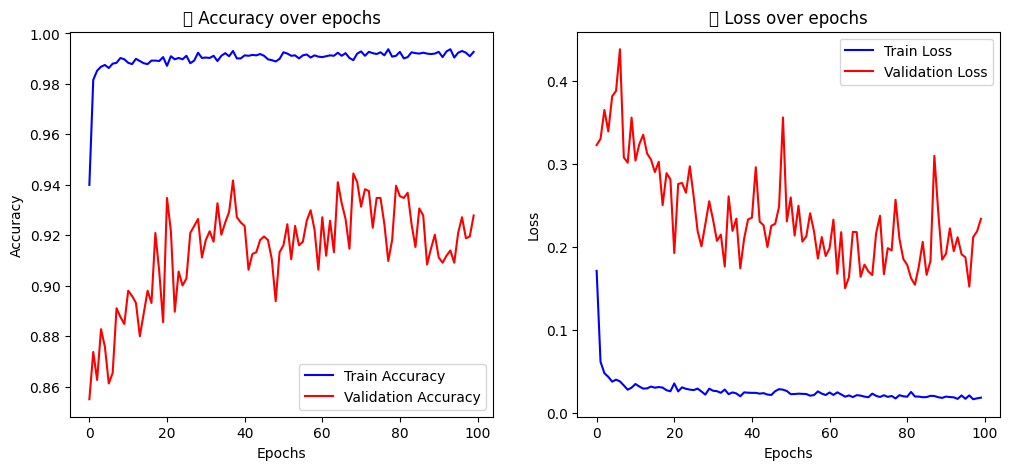

In [8]:
import matplotlib.pyplot as plt


history_dict = history_g.history  

plt.figure(figsize=(12, 5))

# กราฟ Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy', color='b')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('📈 Accuracy over epochs')

# กราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss', color='b')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('📉 Loss over epochs')

plt.show()
